## Required Imports

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.kernel_ridge import KernelRidge
import time
import itertools
import multiprocessing
import matplotlib.pyplot as plt

## Utility Functions

In [2]:
def get_data_path(data_name="KC_Housing", data_file_name="kc_house_data.csv"):
    """  Gets the data path, specific to the project configuration.
    
    :return path to data
    """
    
    proj_dirs = os.getcwd().split("code")
    data_dir = os.path.join(proj_dirs[0], "Data")
    data_path = os.path.join(data_dir, data_name, data_file_name)
    
    return data_path
    
def get_quad_noise_data(quantity=1000, val_ratio=0.10, test_ratio=0.10):
    """ Creates noisy 2D quadratic function
    
    :return x and y values
    """
    np.random.seed(10)
    
    x = np.array([i*np.pi/180 for i in range(60,300,4)])
    y = np.sin(x) + np.random.normal(0,0.15,len(x))
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_ratio)
    
    train = [x_train, y_train]
    val = [x_val, y_val]
    test = [x_test, y_test]
    
    return train, val, test
    
    
def preprocess_housing_data(standardize_data=False, val_ratio=0.10, test_ratio=0.10):
    """  Loads housing data, preprocesses and returns train, val, test sets
    
    :param standardize_data boolean whether to standardize the data
    :return train, val, test sets
    """
    data_path = get_data_path()
    kc = pd.read_csv(data_path)
    
    kc = kc.drop(['id', 'date', 'view', 'waterfront', 'zipcode', 'lat', 'long', 'yr_renovated'],axis=1)
    
    # extract our target variable -- House prices -- into an array 
    y = kc.price.values

    # Drop price from the house dataframe 
    kc = kc.drop(['price'], axis=1)

    # Create a matrix from the remaining data
    X = kc.values

    # Store the column/feature names into a list "colnames"
    colnames = kc.columns
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_ratio)
    
    train = [x_train, y_train]
    val = [x_val, y_val]
    test = [x_test, y_test]
    
    return train, val, test, colnames

## Metrics

In [3]:
def calc_rmse(truth, predicted):
    """  Gets the mean squared error between the truth and predicted samples.
    
    Assumes the matrices are samples by features (rows x columns).
    
    """
    
    if type(truth) is np.ndarray and type(predicted) is np.ndarray:
        if truth.shape == predicted.shape:
            rmse = np.sqrt(np.mean(np.square(truth - predicted)))
        else:
            print("Truth and predicted arrays must be the same shape")
            rmse = None
    else:
        print("Convert truth and predicted arrays to numpy arrays before MSE calculation")
        rmse = None
        
    return rmse


def calc_mse(truth, predicted):
    """  Gets the mean squared error between the truth and predicted samples.
    
    Assumes the matrices are samples by features (rows x columns).
    
    """
    
    if type(truth) is np.ndarray and type(predicted) is np.ndarray:
        if truth.shape == predicted.shape:
            mse = np.mean(np.square(truth - predicted))
        else:
            print("Truth and predicted arrays must be the same shape")
            mse = None
    else:
        print("Convert truth and predicted arrays to numpy arrays before MSE calculation")
        mse = None
        
    return mse
    
def calc_mape(truth, predicted):
    """ Calculates mean absolute percentage error
    
    """
    
    if type(truth) is np.ndarray and type(predicted) is np.ndarray:
        if truth.shape == predicted.shape:
            return np.mean(np.abs((truth - predicted) / truth)) * 100
        else:
            print("Truth and predicted arrays must be the same shape")
    else:
        print("Convert truth and predicted arrays to numpy arrays before MAPE calculation")
            
    

## Visualizations

In [4]:
def plot_model_predictions(model, X, y):
    """  Plots the model predictions using X and overlays the truth values y
    
    Assume this is a 2-D problem.
    
    """
    if X.ndim == 1:
        X = np.expand_dims(X, axis=1)
    
    if X.shape[1] == 1:
        fig, ax = plt.subplots(1,1, figsize=(15, 7))
        ax.scatter(X, model.predict(X), c='c', label="Model")
        ax.scatter(X, y, c='k', label="Truth")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        plt.legend()
    else:
        print("Plotting Model Predictions can only be done with 1 input dimension.")
        

## Regression Functions

In [5]:
def fit_lasso(X, y, lam=0.2, normalize=True, **kwargs):
    """  Fit the lasso function using X and y.
    
    """
    if X.ndim == 1:
        X = np.expand_dims(X, axis=1)
    
    # Set up the L1
    lasso = Lasso(alpha=lam, normalize=normalize)
    
    # Fit the regressor to the data
    lasso.fit(X, y)
    
    # Compute the coefficients
    lasso_coef = lasso.coef_
    
    return lasso

def fit_ridge(X, y, lam=0.5, normalize=True, **kwargs):
    """ Performs ridge regression on the training data
    
    """
    
    # Set up L2 Regression
    ridge = Ridge(alpha=lam, normalize=normalize)
    if X.ndim == 1:
        X = np.expand_dims(X, axis=1)
    
    # Fit the regressor to the data
    ridge.fit(X, y)
    
    return ridge

def fit_kernel_ridge(X, y, lam=0.5, kernel='linear', gamma=1, degree=1, **kwargs):
    """ Performs kernel ridge regression on the training data
    
    """
    
    ridge = KernelRidge(alpha=lam, kernel=kernel, gamma=gamma, degree=degree)
    if X.ndim == 1:
        X = np.expand_dims(X, axis=1)
    
    # Fit the regressor to the data
    ridge.fit(X, y)
    
    return ridge

In [6]:
class regression:
    def __init__(self,
                method,
                dataset,
                **kwargs):
        
        self.method = method
        self.dataset = dataset
        
        self.x_train = None
        self.y_train = None
        self.x_val = None
        self.y_val = None
        self.x_test = None
        self.y_test = None
        self.model = None
        
        self.__dict__.update((k, v) for k, v in kwargs.items())
        
        
    def get_training_data(self):
        """ Loads the training sets
        
        """
        if self.dataset == "housing":
            train, val, test, colnames = preprocess_housing_data()
        elif self.dataset == "quad_noise":
            train, val, test = get_quad_noise_data()
            
        self.x_train, self.y_train = train
        self.x_val, self.y_val = val
        self.x_test, self.y_test = test
        
    def fit_regression(self):
        """ Fits the data using fitting algorithm.
        
        """
        if self.x_train is not None:
            if self.method == "lasso":
                self.model = fit_lasso(self.x_train, self.y_train, self.lam, self.normalize)
            elif self.method == 'ridge':
                self.model = fit_ridge(self.x_train, self.y_train, self.lam, self.normalize)
            elif self.method == 'kernel_ridge':
                self.model = fit_kernel_ridge(self.x_train, self.y_train, self.lam, self.kernel,
                                              self.gamma, self.degree)
            else:
                print("Unknown Regression Model Specified")
                self.model = None
    
    def get_val_predictions(self):
        """ Makes predictions on the val set
        
        """
        
        if self.x_val.ndim == 1:
            self.x_val = np.expand_dims(self.x_val, axis=1)
        
        y_pred = self.model.predict(self.x_val)
        
        return y_pred
            

## Single Experiment

* First make sure your code works for a single set of parameters

In [7]:
exp_config = {
    "method": "kernel_ridge",
    "lam": 0.1,
    "normalize": False,
    "dataset": "quad_noise",
    "kernel": "polynomial",
    "gamma": 1,
    "degree": 3
}

# Initialize Regression Function
regression_method = regression(**exp_config)

# Load the training data
regression_method.get_training_data()

# Fit the regression method
regression_method.fit_regression()

# Get Validation Set Predictions
y_pred = regression_method.get_val_predictions()

# Get Validation Metrics
val_mse = calc_mse(regression_method.y_val, y_pred)
val_rmse = calc_rmse(regression_method.y_val, y_pred)
val_mape = calc_mape(regression_method.y_val, y_pred)

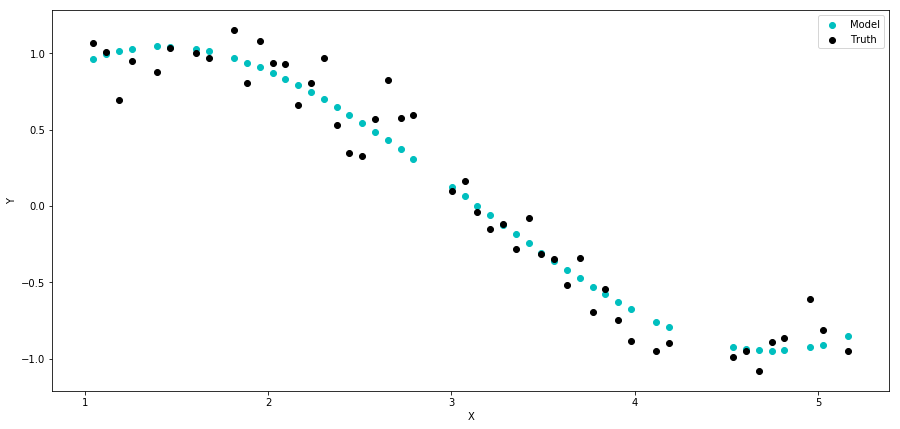

In [8]:
if regression_method.dataset == "quad_noise":
    plot_model_predictions(regression_method.model, regression_method.x_train, regression_method.y_train)

## Hyperparameter Sweep

* Now create a list of experiment parameters and save metrics

In [9]:
def create_exp_list(base_dict, varying_params):
    """  Creates list of experiment dictionaries with varying hyperparameters
    
    """
    
    all_exps = []
    keys, values = zip(*varying_params.items())
    for i, v in enumerate(itertools.product(*values)):
        experiment = dict(zip(keys, v))
        
        # Create a full experiment dictionary
        base_dict.update(experiment)
        all_exps.append(base_dict.copy())
    return all_exps

In [10]:
# Create a list of valid experiment configurations
base_poly = {
    "method": "kernel_ridge",
    "lam": 0.1,
    "normalize": False,
    "dataset": "quad_noise",
    "kernel": "polynomial",
    "gamma": 1,
    "degree": 2
}

poly_exps = {
    "lam": np.linspace(0.1, 1.0, 10),
    "degree": np.arange(1, 10)
}

base_rbf = {
    "method": "kernel_ridge",
    "lam": 0.1,
    "normalize": False,
    "dataset": "quad_noise",
    "kernel": "rbf",
    "gamma": 2,
    "degree": 1
}

rbf_exps = {
    "lam": np.linspace(0.1, 1.0, 10),
    "gamma": np.logspace(-3, 3, 10)
}

all_poly = create_exp_list(base_poly, poly_exps)
all_rbf = create_exp_list(base_rbf, rbf_exps)
all_exps = np.concatenate((all_poly, all_rbf), axis=0)

## Sequential Experiments in a loop

In [11]:
results = []
models = []
print("Fitting {} Models".format(len(all_exps)))
start = time.time()
for exp in all_exps:
    # Initialize Regression Function
    regression_method = regression(**exp)

    # Load the training data
    regression_method.get_training_data()

    # Fit the regression method
    regression_method.fit_regression()

    # Get Validation Set Predictions
    y_pred = regression_method.get_val_predictions()
    models.append(regression_method.model)

    # Get Validation Metrics
    val_mse = calc_mse(regression_method.y_val, y_pred)
    val_rmse = calc_rmse(regression_method.y_val, y_pred)
    val_mape = calc_mape(regression_method.y_val, y_pred)
    
    new_exp = exp.copy()
    new_exp['mse'] = val_mse
    new_exp['rmse'] = val_rmse
    new_exp['mape'] = val_mape
    
    results.append(new_exp)
    
stop = time.time()
print("Fitting Completed in {} seconds".format(np.around(stop-start, 4)))

Fitting 190 Models
Fitting Completed in 0.1606 seconds


## Multiprocessing

In [12]:
def train_model(params):
    # Initialize Regression Function
    regression_method = regression(**params)

    # Load the training data
    regression_method.get_training_data()

    # Fit the regression method
    regression_method.fit_regression()

    # Get Validation Set Predictions
    y_pred = regression_method.get_val_predictions()

    # Get Validation Metrics
    val_mse = calc_mse(regression_method.y_val, y_pred)
    val_rmse = calc_rmse(regression_method.y_val, y_pred)
    val_mape = calc_mape(regression_method.y_val, y_pred)
    
    new_exp = params.copy()
    new_exp['mse'] = val_mse
    new_exp['rmse'] = val_rmse
    new_exp['mape'] = val_mape
    
    return [regression_method.model, new_exp]

In [13]:
pool = multiprocessing.Pool() # Use all available cores

# The .get() function saves the returned result
print("Fitting {} Models".format(len(all_exps)))
start = time.time()

mp_results = pool.map_async(func=train_model, iterable=all_exps).get()
pool.close()
pool.join()
stop = time.time()
print("Model Fitting Completed in {} seconds".format(np.around(stop-start, 4)))

models = [a[0] for a in mp_results]
results = [a[1] for a in mp_results]

Fitting 190 Models
Model Fitting Completed in 0.2047 seconds


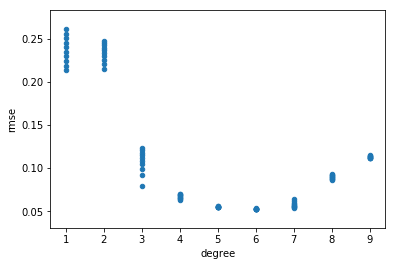

In [14]:
# This only makes sense if the models have the same string labels for hyperparameters
result_df = pd.DataFrame(results)
poly_df = result_df.loc[result_df['kernel'] == 'polynomial' ]
rbf_df = result_df.loc[result_df['kernel'] == 'rbf']
_ = poly_df.plot.scatter(x='degree', y='rmse')

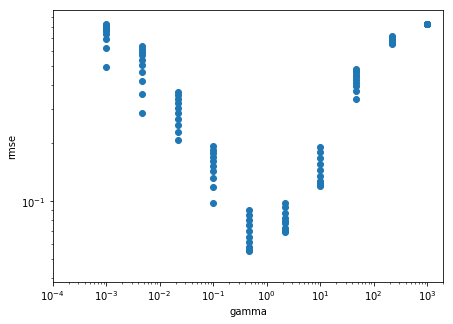

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter(rbf_df['gamma'], rbf_df['rmse'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.0001, 2000])
ax.set_xlabel("gamma")
ax.set_ylabel("rmse")
plt.show()

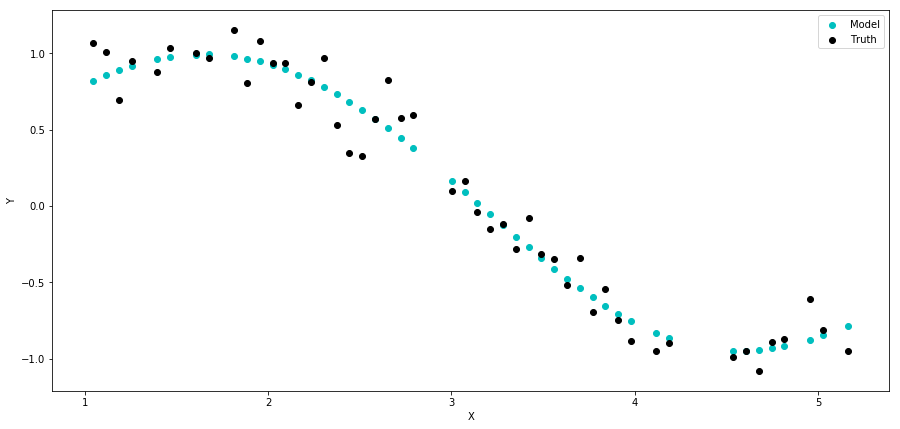

In [16]:
# Find minimum rmse result on validation set
best_exp = result_df.iloc[result_df['mse'].idxmin()]

best_model = models[result_df['mse'].idxmin()]
temp_model = regression(**best_exp)

# Load the training data
temp_model.get_training_data()
plot_model_predictions(best_model, temp_model.x_train, temp_model.y_train)

In [17]:
print(best_exp)

dataset        quad_noise
degree                  6
gamma                   1
kernel         polynomial
lam                     1
mape               6.2298
method       kernel_ridge
mse            0.00275938
normalize           False
rmse            0.0525298
Name: 86, dtype: object


### Report Test Set Results

In [18]:
temp_model = regression(**best_exp)
temp_model.get_training_data()
test_pred = best_model.predict(np.expand_dims(temp_model.x_test, axis=1))
print("RMSE: {}".format(calc_rmse(test_pred, temp_model.y_test)))

RMSE: 0.10839692390365888
